In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])

import seaborn as sns

In [2]:
data1 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee1.parquetoutput.parquet')
data2 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee2.parquetoutput.parquet')
data3 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee3.parquetoutput.parquet')

In [3]:
data = pd.concat([data1, data2, data3])

In [4]:
drop_list = ['runNumber', 'eventNumber', 'mcEventNumber', 'el_index', 'el_firstEgMotherTruthType',
       'el_firstEgMotherTruthOrigin', 'truthType',
       'truthOrigin', 'neflowisol20','truthel_e_dressed', 
       'truthel_pt_dressed', 'truthel_eta_dressed',
       'truthel_phi_dressed', 'truthel_m', 'truthel_px', 'truthel_py',
       'truthel_pz', 'truthel_E', 'truthel_pdgId', 'truthel_ptcone30',
       'truthel_etcone20', 'truthel_ParticleOrigin', 'truthel_Classification',
       'truthel_barcode', 'truthel_status', 'truthel_nPhotons_dressed', 'truth_dR', 'pt', 'm',
       'el_topoetcone20_CloseByCorr', 'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr']

In [5]:
print(f'{np.sum(data['truthOrigin']==13)/len(data)*100.:.2f}% of the data is from Z bosons')

24.42% of the data is from Z bosons


In [6]:
# balance the data
data_z = data[data['truthOrigin']==13]
data_non_z = data[data['truthOrigin']!=13].sample(len(data_z), random_state=12)
data = pd.concat([data_z, data_non_z])

print(f'{np.sum(data['truthOrigin']==13)/len(data)*100.:.2f}% of the data is from Z bosons')

50.00% of the data is from Z bosons


In [7]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(data, data['truthOrigin']==13, test_size=0.2, random_state=42)

X_test_full = X_test.copy()
X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)
print(X_train.columns)


Index(['eta', 'phi', 'charge', 'f1', 'DNN_pel', 'DNN_pcf', 'DNN_ppc',
       'DNN_phf', 'DNN_ple', 'DNN_plh', 'el_DFCommonElectronsECIDS',
       'el_DFCommonElectronsECIDSResult', 'GSF_dR', 'GSF_d0', 'GSF_z0',
       'GSF_theta', 'GSF_phi', 'GSF_qOverP', 'GSF_chiSquared', 'GSF_var_0',
       'GSF_var_1', 'GSF_var_2', 'GSF_var_3', 'GSF_var_4', 'InDet_dR',
       'InDet_d0', 'InDet_z0', 'InDet_theta', 'InDet_phi', 'InDet_var_0',
       'InDet_var_1', 'InDet_var_2', 'InDet_var_3', 'InDet_var_4',
       'ptvarcone20', 'topoetcone20', 'topoetcone40',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_core57cellsEnergyCorrection', 'el_topoetcone20ptCorrection',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500'],
      dtype='object')



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: auc 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.04898804714416193
     .. Evaluation score (greater-better): auc: 0.9982911785964986
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.046401327216210854
     .. Evaluation score (greater-better): auc: 0.9983973830272831
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.08832141337158037
     .. Evaluation score (greater-better): auc: 0.9974726325569925
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.04792637317937905

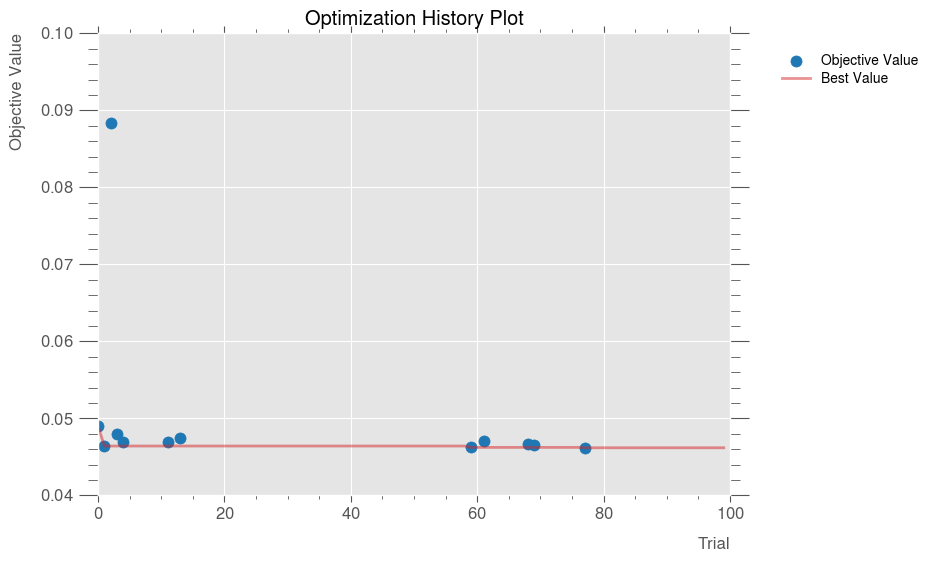

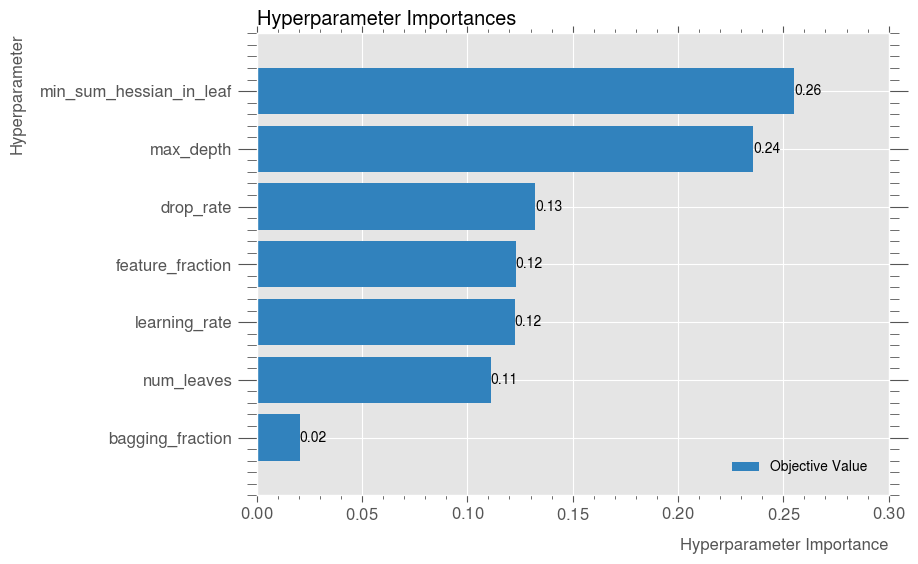

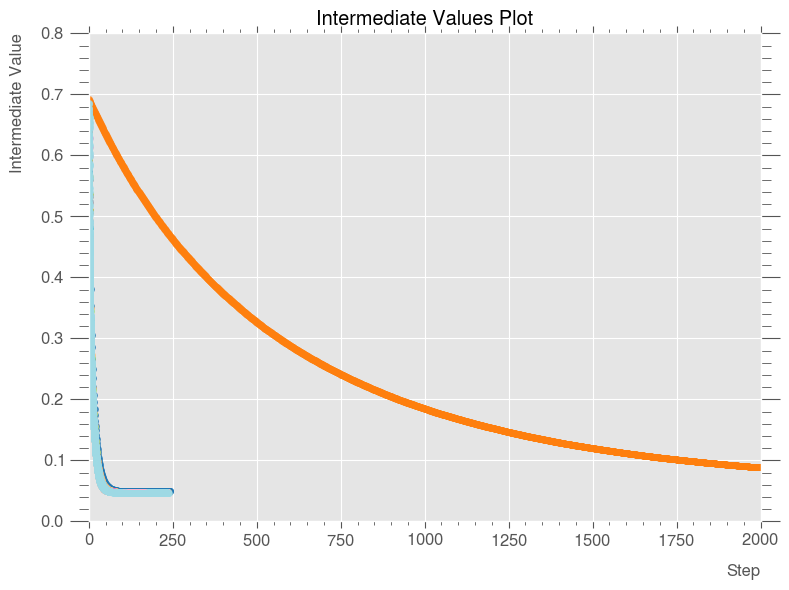

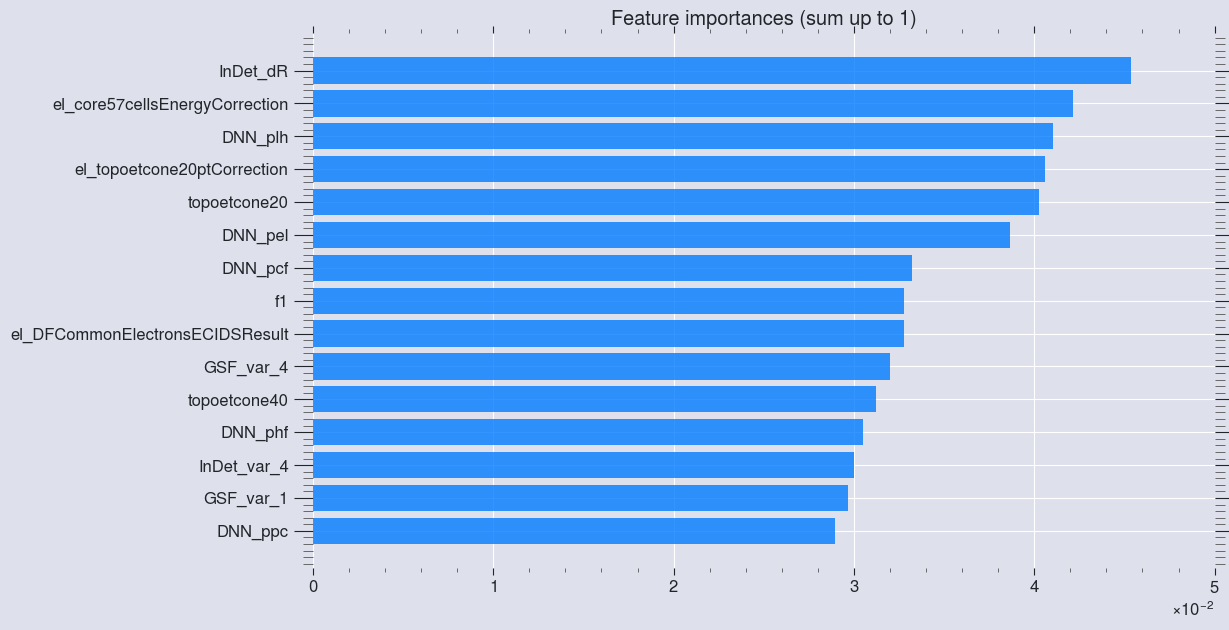


     . Optuna hyperparameters optimization finished
     .. Best trial number:77    |     log_loss:          0.04617513742834726
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 6 min 50.167 sec


In [8]:
tuner = RapidGBMTuner(metric='auc', trials=100, refit=True, verbosity=1, visualization=True, seed=414243)#, grid='h,learning_rate')

tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05,0.4)
# Fit tuner for each set of input_data
tuner.fit(X_train, y_train)

no


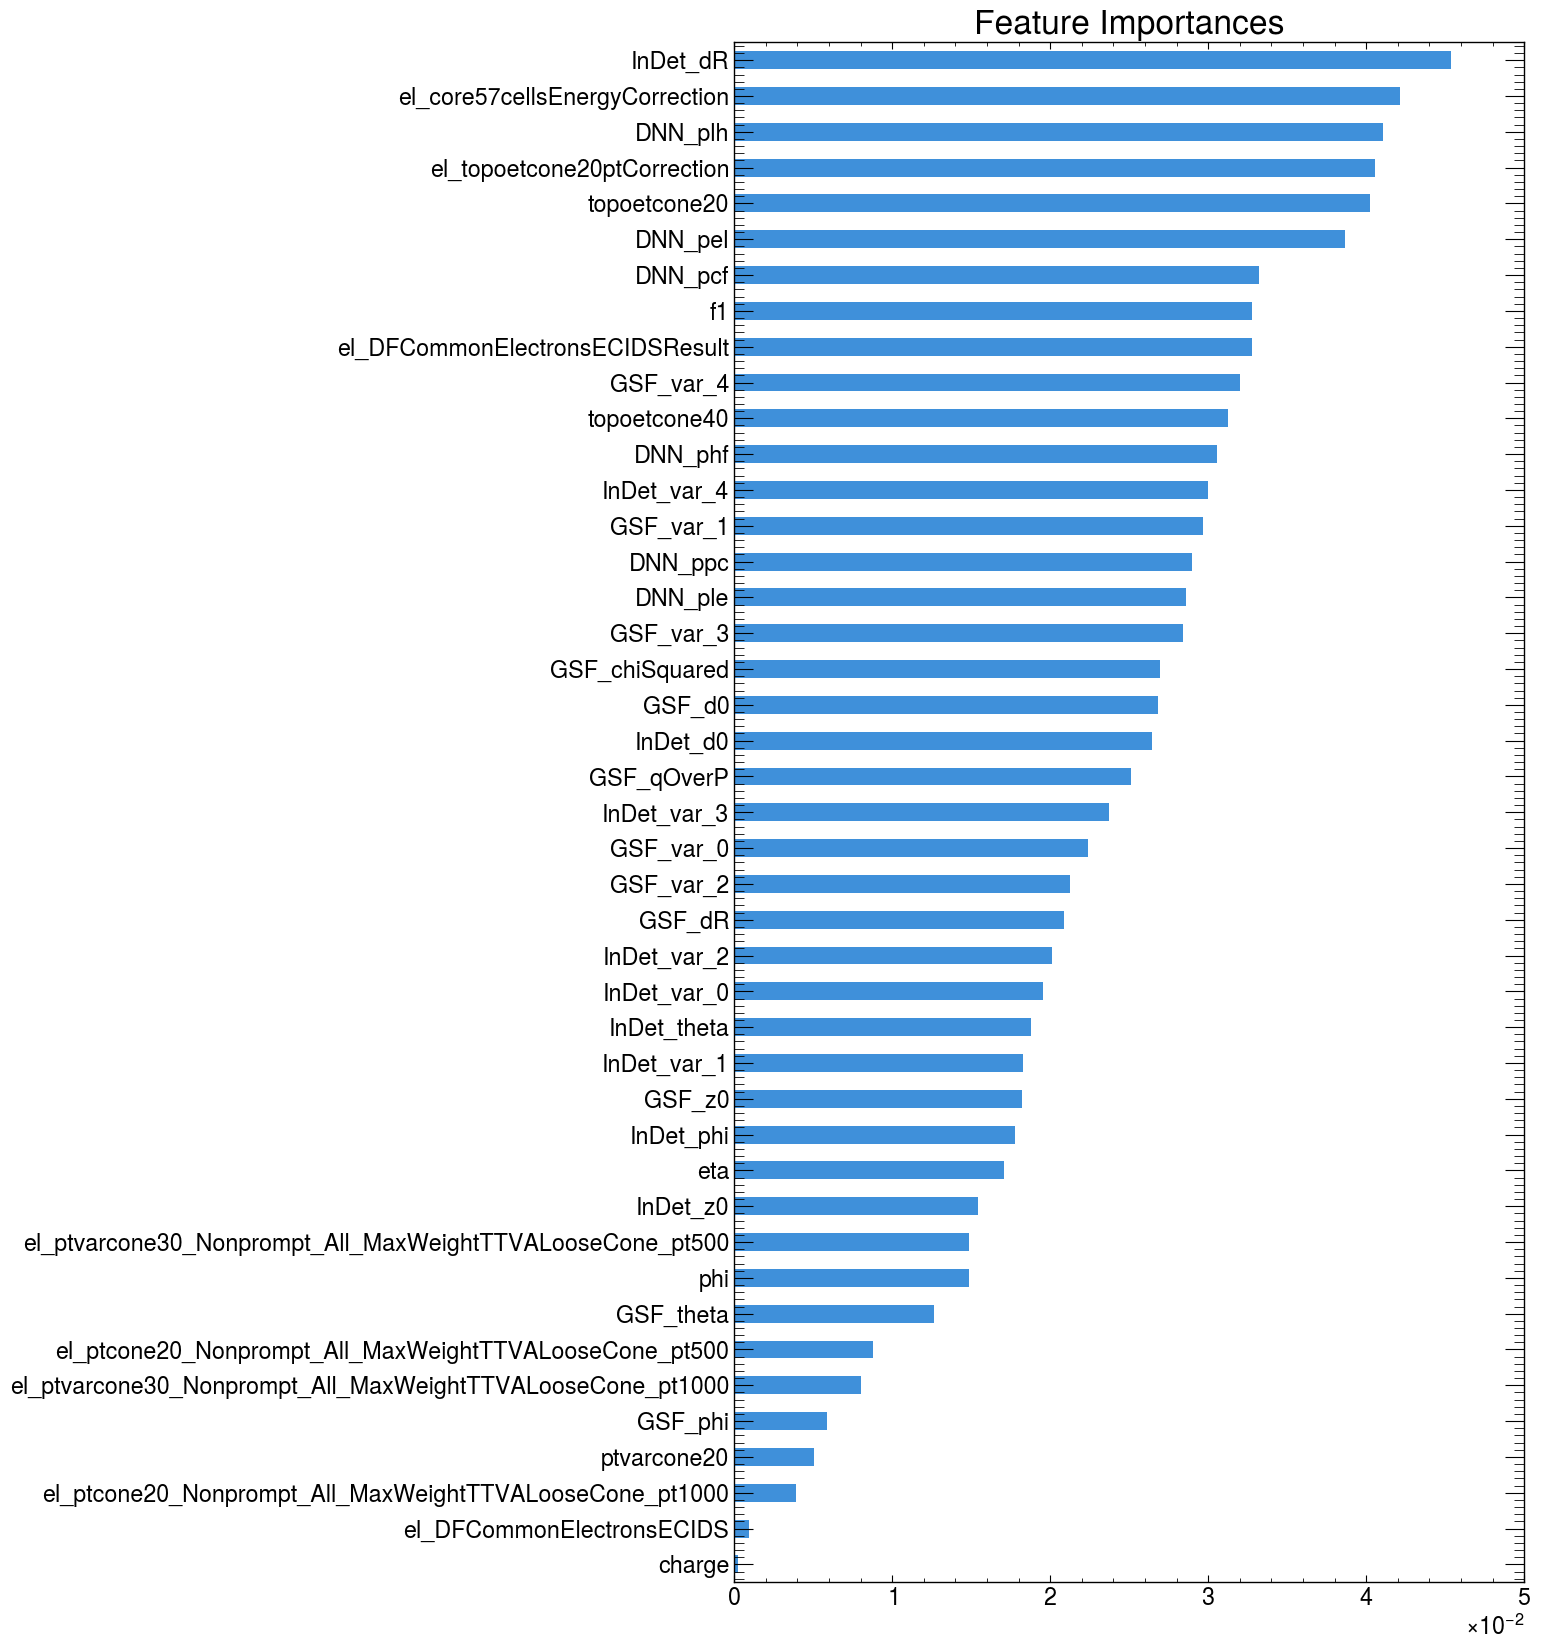

In [9]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(figsize=(10, 20))
ax.set_title('Feature Importances')
tuner.feature_importances.sort_values().plot(ax=ax,kind='barh')
# ax.set_xticklabels(tuner.feature_importances.sort_values().index, rotation=45)
print('no')

Text(0.5, 1.0, 'Receiver Operating Characteristic')

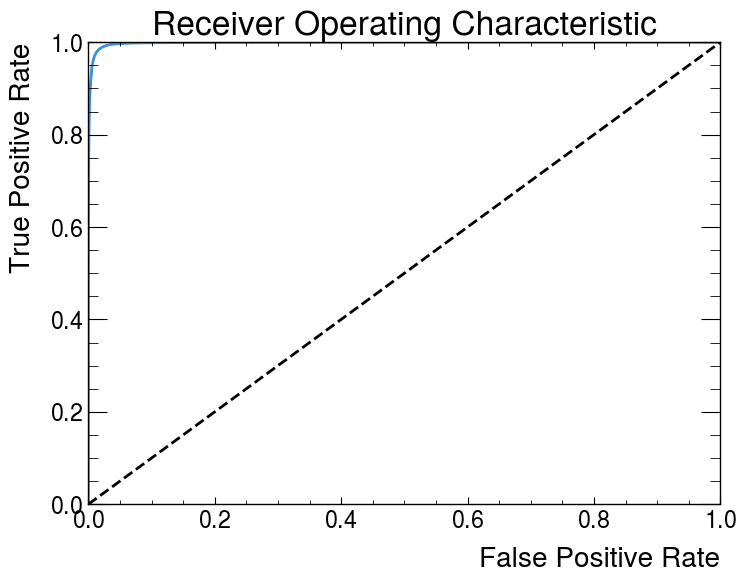

In [10]:
# roc curve
y_pred = tuner.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')

In [11]:
file_path = '/groups/hep/kinch/pred_e_m/samples_processed/ttbar/'

from pathlib import Path
file_list = Path(file_path).rglob('*processed.parquet')
ttbar_data = []
for file in file_list:
    ttbar_data.append(pd.read_parquet(file))

ttbar_data = pd.concat(ttbar_data)

In [12]:
print(X_test_full.columns)
print(ttbar_data.columns)

Index(['runNumber', 'eventNumber', 'mcEventNumber', 'el_index', 'pt', 'eta',
       'phi', 'charge', 'm', 'f1', 'DNN_pel', 'DNN_pcf', 'DNN_ppc', 'DNN_phf',
       'DNN_ple', 'DNN_plh', 'el_firstEgMotherTruthType',
       'el_firstEgMotherTruthOrigin', 'el_DFCommonElectronsECIDS',
       'el_DFCommonElectronsECIDSResult', 'GSF_dR', 'GSF_d0', 'GSF_z0',
       'GSF_theta', 'GSF_phi', 'GSF_qOverP', 'GSF_chiSquared', 'GSF_var_0',
       'GSF_var_1', 'GSF_var_2', 'GSF_var_3', 'GSF_var_4', 'InDet_dR',
       'InDet_d0', 'InDet_z0', 'InDet_theta', 'InDet_phi', 'InDet_var_0',
       'InDet_var_1', 'InDet_var_2', 'InDet_var_3', 'InDet_var_4',
       'ptvarcone20', 'topoetcone20', 'topoetcone40', 'truthType',
       'truthOrigin', 'neflowisol20',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr',
       'el_topoetcone20_CloseByCorr',


In [13]:
def compare_dataframe_columns(df1, df2):
    """
    Compare the columns of two DataFrames and print the differences.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame.
    df2 (pd.DataFrame): The second DataFrame.
    """
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)

    # Columns in df1 but not in df2
    diff1 = columns_df1 - columns_df2
    if diff1:
        print("Columns in df1 but not in df2:")
        for col in diff1:
            print(col)
    else:
        print("No columns in df1 that are not in df2.")

    # Columns in df2 but not in df1
    diff2 = columns_df2 - columns_df1
    if diff2:
        print("Columns in df2 but not in df1:")
        for col in diff2:
            print(col)
    else:
        print("No columns in df2 that are not in df1.")


In [14]:
compare_dataframe_columns(X_test_full, ttbar_data)

Columns in df1 but not in df2:
el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr
el_topoetcone20_CloseByCorr
el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr
No columns in df2 that are not in df1.


In [15]:
ttbar_prediction = tuner.predict_proba(ttbar_data.drop(drop_list[:-3], axis=1))

no


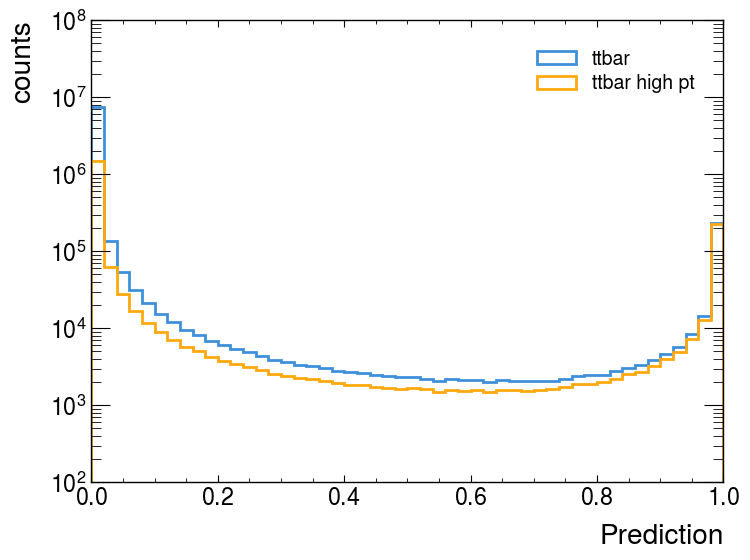

In [16]:
ttbar_high_pt = ttbar_prediction[ttbar_data['pt'] > 10000]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(ttbar_prediction, bins=50, histtype='step', lw=2, label='ttbar')
ax.hist(ttbar_high_pt, bins=50, histtype='step', lw=2, label='ttbar high pt')
ax.set_xlabel('Prediction')
ax.set_ylabel('counts')
ax.legend()
ax.set_yscale('log')
print('no')


Text(150.25, 1, 'True')

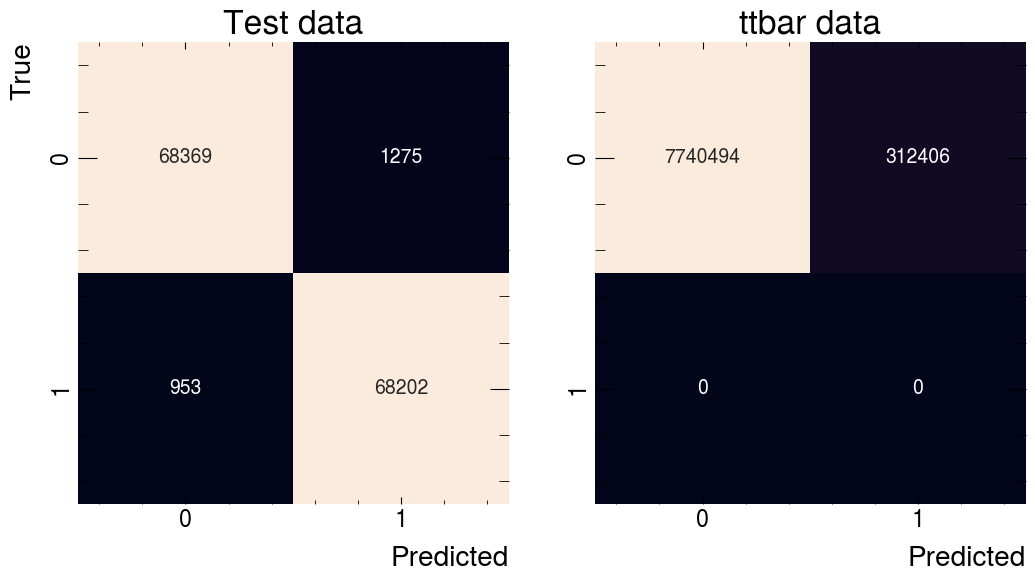

In [17]:
#confusion matrix of model on test data and ttbar data
fig, ax = plt.subplots(1,2, figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred>0.5), annot=True, fmt='d', ax=ax[0], cbar=False)
sns.heatmap(confusion_matrix(np.zeros(len(ttbar_prediction)), ttbar_prediction>0.5), annot=True, fmt='d', ax=ax[1], cbar=False)
ax[0].set_title('Test data')
ax[1].set_title('ttbar data')
ax[0].set_xlabel('Predicted')
ax[1].set_xlabel('Predicted')
ax[0].set_ylabel('True')


In [18]:
print(ttbar_data['truthOrigin'][ttbar_prediction>0.5].value_counts())
print(ttbar_data['truthOrigin'][ttbar_prediction<0.5].value_counts())

truthOrigin
10    252774
26     18923
0      16157
5      13386
25      3942
42      1861
12      1185
40       786
33       661
6        661
9        472
37       381
38       375
27       372
23       286
32       143
7         21
24        10
34         5
35         3
31         1
8          1
Name: count, dtype: int64
truthOrigin
0     6268629
42     653873
5      495512
25      89014
26      87361
23      67638
6       24193
10      14220
12       9065
9        5237
33       4100
40       4019
24       3349
32       3328
31       2719
27       1803
38       1694
34       1616
37       1369
7        1250
35        431
30         71
29          2
8           1
Name: count, dtype: int64


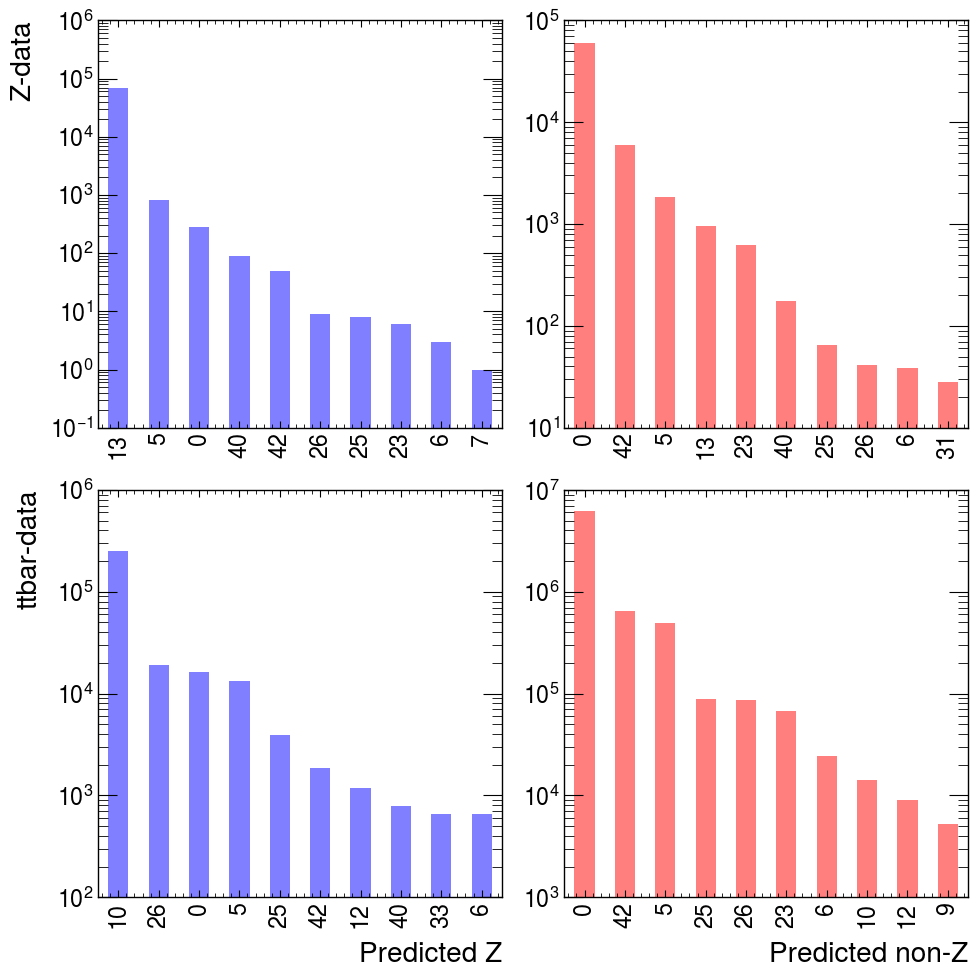

In [19]:
fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax = ax.flatten()
X_test_full['truthOrigin'][y_pred>0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[0], color='b', alpha=0.5)
X_test_full['truthOrigin'][y_pred<0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[1], color='r', alpha=0.5)
ttbar_data['truthOrigin'][ttbar_prediction>0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[2], color='b', alpha=0.5)
ttbar_data['truthOrigin'][ttbar_prediction<0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[3], color='r', alpha=0.5)


ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('Z-data')
ax[2].set_ylabel('ttbar-data')
ax[2].set_xlabel('Predicted Z')
ax[3].set_xlabel('Predicted non-Z')
for i in range(4):
    ax[i].set_yscale('log')
fig.tight_layout()

In [20]:
print(X_test_full['truthOrigin'][y_pred>0.5].value_counts())
print(X_test_full['truthOrigin'][y_pred<0.5].value_counts())

truthOrigin
13    68202
5       822
0       282
40       91
42       50
26        9
25        8
23        6
6         3
7         1
32        1
38        1
33        1
Name: count, dtype: int64
truthOrigin
0     59480
42     6015
5      1849
13      953
23      616
40      175
25       65
26       41
6        39
31       28
24       26
38       17
7         7
32        3
9         3
30        3
34        1
27        1
Name: count, dtype: int64


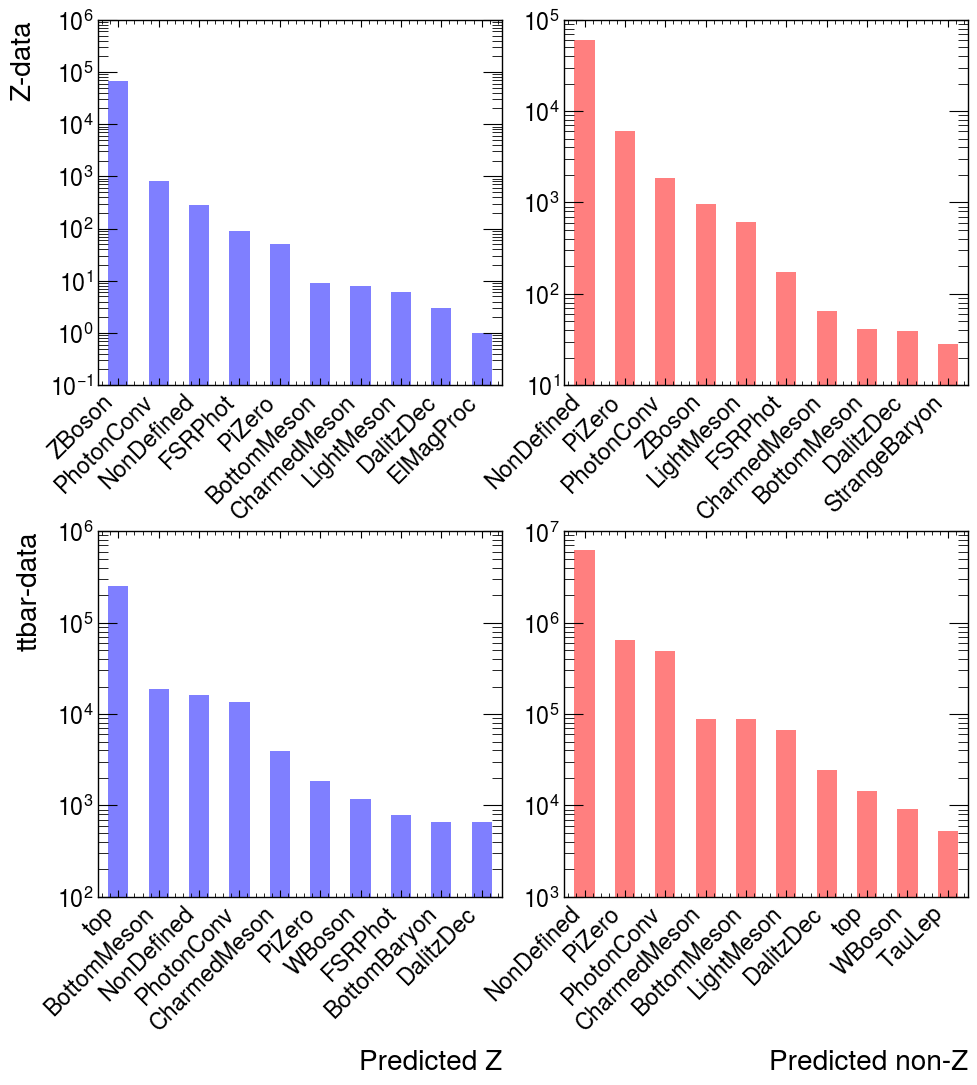

In [21]:
origins = [
    "NonDefined", "SingleElec", "SingleMuon", "SinglePhot", "SingleTau",
    "PhotonConv", "DalitzDec", "ElMagProc", "Mu", "TauLep", "top",
    "QuarkWeakDec", "WBoson", "ZBoson", "Higgs", "HiggsMSSM", "HeavyBoson",
    "WBosonLRSM", "NuREle", "NuRMu", "NuRTau", "LQ", "SUSY", "LightMeson",
    "StrangeMeson", "CharmedMeson", "BottomMeson", "CCbarMeson", "JPsi",
    "BBbarMeson", "LightBaryon", "StrangeBaryon", "CharmedBaryon", 
    "BottomBaryon", "PionDecay", "KaonDecay", "BremPhot", "PromptPhot", 
    "UndrPhot", "ISRPhot", "FSRPhot", "NucReact", "PiZero", "DiBoson",
    "ZorHeavyBoson", "QCD", "OtherBSM", "MultiBoson"
]


fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax = ax.flatten()
X_test_full['truthOrigin'][y_pred>0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[0], color='b', alpha=0.5)
X_test_full['truthOrigin'][y_pred<0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[1], color='r', alpha=0.5)
ttbar_data['truthOrigin'][ttbar_prediction>0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[2], color='b', alpha=0.5)
ttbar_data['truthOrigin'][ttbar_prediction<0.5].value_counts().nlargest(10).plot(kind='bar', ax=ax[3], color='r', alpha=0.5)


ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('Z-data')
ax[2].set_ylabel('ttbar-data')
ax[2].set_xlabel('Predicted Z')
ax[3].set_xlabel('Predicted non-Z')
for i in range(4):
    ax[i].set_yscale('log')
fig.tight_layout()

for i in range(4):
    new_labels = []
    for tick in range(10):
        label = ax[i].get_xticklabels()[tick].get_text()
        new_labels.append(origins[int(label)])
    ax[i].set_xticklabels(new_labels, rotation=45, ha='right')
# print(ax[0].get_xticklabels()[0].get_text())

# for i in range(4):
#     ax[i].set_xticklabels([origins[int(label)] for label in ax[i].get_xticks()], rotation=45, ha='right')

fig.subplots_adjust(hspace=0.4)

In [22]:
print(len(data['InDet_dR']))
print((data['InDet_dR'].to_numpy()==-1).sum()/len(data['InDet_dR']))
print((ttbar_data['InDet_dR'].to_numpy()==-1).sum()/len(ttbar_data['InDet_dR']))

693992
0.017165903929728298
4.7684685020303244e-05
